In [3]:
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import requests 
PURPLE = "\033[38;5;165m"
BOLD_PURPLE = "\033[1;38;5;165m"
BLACK = "\033[1;30m"
BOLD_BLACK = "\033[1;30m"
import math
# ============================
# Imports per your coding style
# ============================
import pandas_ta as ta  
from app.backtesthelper import AlgrowConnect
from app.backtestutils import *  # expects: format_date, get_dates_between, etc.
from app.serverhelper import *
# ============================
# Fetch Nifty 50 Universe
# ============================
STOCKCODE = "NIFTY"   
BACKTEST_START_DATE = "01-01-2025"
BACKTEST_END_DATE   = "30-03-2025"
BACKTEST_START_DATE = format_date(BACKTEST_START_DATE, 'object')
BACKTEST_END_DATE   = format_date(BACKTEST_END_DATE, 'object')
TF = 5
algrow = AlgrowConnect()
spot_df = larger_df = shorter_df = None
TRADE_CAPITAL =500000
start_date = BACKTEST_START_DATE - timedelta(days=10)
end_date = BACKTEST_END_DATE

print(f"Fetching data for {STOCKCODE}")
spot_df = algrow.get_data(start_date, end_date, STOCKCODE, "", "", "", interval="1MINUTE")
spot_df = spot_df[spot_df.index.time >= datetime.time(9, 15)]

spot_df = spot_df.sort_index()
lot_size = algrow.get_lot_size(STOCKCODE)
print(f"Lot size of {STOCKCODE} =  {lot_size}")
tf_df = spot_df.resample(f"{TF}T", offset="15min").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last"
}).dropna()
display(spot_df)
display(tf_df)

Fetching data for NIFTY
Lot size of NIFTY =  75


,open,high,low,close,open_interest,volume
datetime,,,,,,
2024-12-23 09:15:00,23735.90,23771.80,23734.00,23758.95,0,0
2024-12-23 09:16:00,23758.60,23785.50,23748.50,23778.20,0,0
2024-12-23 09:17:00,23777.05,23777.05,23748.50,23758.95,0,0
2024-12-23 09:18:00,23757.70,23769.55,23755.80,23755.80,0,0
2024-12-23 09:19:00,23755.95,23772.25,23753.30,23769.55,0,0
...,...,...,...,...,...,...
2025-03-28 15:25:00,23500.25,23502.50,23485.75,23490.40,0,0
2025-03-28 15:26:00,23490.75,23494.35,23486.75,23494.05,0,0
2025-03-28 15:27:00,23494.20,23497.45,23489.75,23496.80,0,0


,open,high,low,close
datetime,,,,
2024-12-23 09:15:00,23735.90,23785.50,23734.00,23769.55
2024-12-23 09:20:00,23768.85,23805.75,23764.05,23781.15
2024-12-23 09:25:00,23781.75,23783.25,23722.05,23743.70
2024-12-23 09:30:00,23743.85,23792.55,23739.20,23770.00
2024-12-23 09:35:00,23769.35,23776.40,23713.60,23727.60
...,...,...,...,...
2025-03-28 15:05:00,23530.60,23532.95,23520.10,23528.75
2025-03-28 15:10:00,23530.05,23546.25,23524.20,23543.65
2025-03-28 15:15:00,23544.25,23545.30,23497.10,23497.10


In [4]:
from datetime import time, timedelta
import pandas as pd
import time as t_delay
trade_log = []
# TRADE_CAPITAL = 500000        # total capital
MARGIN_PER_LOT = 150000       # approx margin per lot (adjust as per broker)
LOT_SIZE = 65

# ================= ENTRY PRINT FUNCTION =================
def print_entry_details(expiry_dt, strike, side, entry_px, signal_time,
                        spot_close, range_high, range_low, candle):

    print("\n" + "="*65)
    print("🟢 TRADE ENTRY DETAILS")
    print("="*65)

    print(f"Expiry Date        : {expiry_dt}")
    print(f"Strike             : {strike}")
    print(f"Action             : SELL {side}")
    print(f"Entry Premium      : {entry_px}")
    print(f"Entry Date         : {signal_time.date()}")
    print(f"Entry Time         : {signal_time.time()}")
    print(f"Spot Price         : {spot_close}")

    print("\n--- 9:20 Range ---")
    print(f"Range High         : {range_high}")
    print(f"Range Low          : {range_low}")

    print("\n--- Confirmation Candle OHLC ---")
    print(f"Open               : {candle['open']}")
    print(f"High               : {candle['high']}")
    print(f"Low                : {candle['low']}")
    print(f"Close              : {candle['close']}")

    print("="*65)


# ================= STRIKE PICKER =================
def get_strategy_strike(spot_price, side, signal_time):

    expiry_dt = algrow.get_expiry(STOCKCODE, "WEEK", signal_time)

    strike_step = 50   # BANKNIFTY=100 , NIFTY=50 etc

    atm_strike = round(spot_price / strike_step) * strike_step

    return atm_strike, expiry_dt


# ====== MAIN LOOP =================
target_df = tf_df[tf_df.index >= pd.to_datetime(BACKTEST_START_DATE)]
grouped = target_df.groupby(target_df.index.date)
total_points = 0.0

for trading_date, day_data in grouped:

    if trading_date.weekday() != 3:
        continue
    if len(day_data) < 2:
        continue

    range_high = day_data.iloc[1]['high']
    range_low  = day_data.iloc[1]['low']

    trade_active = False

    for i in range(2, len(day_data)):

        current_candle = day_data.iloc[i]
        spot_close = current_candle['close']
        signal_time = current_candle.name

# =========== ENTRY LOGIC =================
        if not trade_active:
        
            is_break_high = current_candle['close'] > range_high
            is_break_low  = current_candle['close'] < range_low
        
            if is_break_high or is_break_low:
        
                if i + 1 < len(day_data):
        
                    confirmation_candle = current_candle
                    entry_candle = day_data.iloc[i + 1]
        
                    side = "PUT" if is_break_high else "CALL"
        
                    signal_time = entry_candle.name
                    spot_close  = entry_candle['open']
        
                    strike, expiry_dt = get_strategy_strike(
                        spot_close, side, signal_time
                    )
        
                    entry_px = 0.0
        
                    for _ in range(3):
                        try:
                            sec_df = algrow.get_data(
                                signal_time,
                                signal_time + timedelta(seconds=15),
                                STOCKCODE, side, strike, expiry_dt,
                                interval="1SECOND"
                            )
        
                            if sec_df is not None and not sec_df.empty:
        
                                exact_tick = sec_df[sec_df.index == signal_time]
        
                                if not exact_tick.empty:
                                    entry_px = exact_tick.iloc[0]["close"]
                                else:
                                    sec_df = sec_df[sec_df.index >= signal_time]
                                    if not sec_df.empty:
                                        entry_px = sec_df.iloc[0]["close"]
        
                                break
        
                        except:
                            t_delay.sleep(0.5)
        
# ===== CAPITAL BASED POSITION SIZE (SELL LOGIC) =================
                    lots = int(TRADE_CAPITAL // MARGIN_PER_LOT)
                    
                    if lots <= 0:
                        print("Insufficient capital for 1 lot")
                        break
                    
                    quantity = lots * LOT_SIZE
                    capital_used = lots * MARGIN_PER_LOT
                    
                    trade_active = True
                    
                    # ENTRY PRINT
                    print_entry_details(
                        expiry_dt,
                        strike,
                        side,
                        entry_px,
                        signal_time,
                        spot_close,
                        range_high,
                        range_low,
                        confirmation_candle
                    )
                    
                    print(f"Lots               : {lots}")
                    print(f"Quantity           : {quantity}")
                    print(f"Margin Used        : {capital_used}")
                    
                    # ================= EXIT LOGIC =================
                    for j in range(i+1, len(day_data)):
                    
                        exit_candle = day_data.iloc[j]
                        ex_close = exit_candle['close']
                        ex_time  = exit_candle.name
                    
                        is_sl = (side == "PUT" and ex_close < range_low) or \
                                (side == "CALL" and ex_close > range_high)
                    
                        is_time_up = ex_time.time() >= time(15, 15)
                    
                        if is_sl or is_time_up:
                    
                            exit_px = 0.0
                    
                            for _ in range(3):
                                try:
                                    exit_sec = algrow.get_data(
                                        ex_time - timedelta(seconds=5),
                                        ex_time + timedelta(seconds=10),
                                        STOCKCODE, side, strike, expiry_dt,
                                        interval="1SECOND"
                                    )
                    
                                    if exit_sec is not None and not exit_sec.empty:
                                        exit_sec = exit_sec[exit_sec.index >= ex_time]
                    
                                        if not exit_sec.empty:
                                            exit_px = exit_sec.iloc[0]["close"]
                                        else:
                                            exit_px = exit_sec.iloc[-1]["close"]
                                        break
                                except:
                                    t_delay.sleep(0.5)
                    
                            # ================= REAL MTM (SELL POSITION) =================
                            points = entry_px - exit_px
                            mtm = round(points * quantity, 2)
                    
                            total_points += mtm
                    
                            print(f"\n❌ EXIT  | {ex_time.time()} | "
                                  f"{'SL HIT' if is_sl else '3:15 PM'}")
                            print(f"Exit Price         : {exit_px}")
                            print(f"Points             : {round(points,2)}")
                            print(f"MTM ₹              : {mtm}")
                            print(f"Running Total ₹    : {round(total_points,2)}")
                    
                            # ================= TRADE LOG APPEND =================
                            trade_log.append({
                                "Stock": STOCKCODE,
                                "Side": side,
                                "Entry_DateTime": signal_time,
                                "Action": "SELL",
                                "Spot_Entry": spot_close,
                                "Strike": strike,
                                "Option_Entry_Price": entry_px,
                                "Lots": lots,
                                "Quantity": quantity,
                                "Margin_Used": capital_used,
                                "Exit_Option_Price": exit_px,
                                "Exit_DateTime": ex_time,
                                "Exit_Reason": "SL HIT" if is_sl else "3:15 PM",
                                "Points": points,
                                "MTM": mtm,
                                "Total_MTM_Running": total_points
                            })
                    
                            break
                    
                    break
print(f"\n{BOLD_PURPLE}FINAL TOTAL: {round(total_points, 2)} Points{BOLD_BLACK}")



🟢 TRADE ENTRY DETAILS
Expiry Date        : 02-01-2025
Strike             : 23800
Action             : SELL PUT
Entry Premium      : 91.3
Entry Date         : 2025-01-02
Entry Time         : 09:40:00
Spot Price         : 23816.95

--- 9:20 Range ---
Range High         : 23788.2
Range Low          : 23755.3

--- Confirmation Candle OHLC ---
Open               : 23783.7
High               : 23829.8
Low                : 23780.4
Close              : 23815.05
Lots               : 3
Quantity           : 195
Margin Used        : 450000

❌ EXIT  | 15:15:00 | 3:15 PM
Exit Price         : 0.2
Points             : 91.1
MTM ₹              : 17764.5
Running Total ₹    : 17764.5

🟢 TRADE ENTRY DETAILS
Expiry Date        : 09-01-2025
Strike             : 23600
Action             : SELL CALL
Entry Premium      : 35.45
Entry Date         : 2025-01-09
Entry Time         : 09:40:00
Spot Price         : 23603.9

--- 9:20 Range ---
Range High         : 23622.25
Range Low          : 23607.8

--- Confirmatio

In [5]:
display(pd.DataFrame(trade_log))

,Stock,Side,Entry_DateTime,Action,Spot_Entry,Strike,Option_Entry_Price,Lots,Quantity,Margin_Used,Exit_Option_Price,Exit_DateTime,Exit_Reason,Points,MTM,Total_MTM_Running
0,NIFTY,PUT,2025-01-02 09:40:00,SELL,23816.95,23800,91.30,3,195,450000,0.20,2025-01-02 15:15:00,3:15 PM,91.10,17764.50,17764.50
1,NIFTY,CALL,2025-01-09 09:40:00,SELL,23603.90,23600,35.45,3,195,450000,38.95,2025-01-09 09:50:00,SL HIT,-3.50,-682.50,17082.00
2,NIFTY,CALL,2025-01-16 09:50:00,SELL,23317.00,23300,32.85,3,195,450000,2.45,2025-01-16 15:15:00,3:15 PM,30.40,5928.00,23010.00
3,NIFTY,PUT,2025-01-23 09:40:00,SELL,23171.45,23150,38.70,3,195,450000,0.15,2025-01-23 15:15:00,3:15 PM,38.55,7517.25,30527.25
4,NIFTY,PUT,2025-01-30 09:35:00,SELL,23190.25,23200,131.10,3,195,450000,0.30,2025-01-30 15:15:00,3:15 PM,130.80,25506.00,56033.25
5,NIFTY,CALL,2025-02-06 09:35:00,SELL,23656.25,23650,67.90,3,195,450000,0.15,2025-02-06 15:15:00,3:15 PM,67.75,13211.25,69244.50
6,NIFTY,PUT,2025-02-13 09:35:00,SELL,23103.65,23100,74.60,3,195,450000,69.00,2025-02-13 15:15:00,3:15 PM,5.60,1092.00,70336.50
7,NIFTY,PUT,2025-02-20 09:40:00,SELL,22891.05,22900,58.20,3,195,450000,63.20,2025-02-20 09:45:00,SL HIT,-5.00,-975.00,69361.50
8,NIFTY,CALL,2025-02-27 09:30:00,SELL,22554.80,22550,44.00,3,195,450000,1.20,2025-02-27 15:15:00,3:15 PM,42.80,8346.00,77707.50
9,NIFTY,CALL,2025-03-06 09:35:00,SELL,22310.90,22300,58.65,3,195,450000,146.10,2025-03-06 12:40:00,SL HIT,-87.45,-17052.75,60654.75


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def generate_performance_report(trade_log):

    if not trade_log:
        print("No trades available.")
        return

    df = pd.DataFrame(trade_log)

    if "Exit_DateTime" not in df.columns:
        print("Exit_DateTime column missing in trade_log")
        return

    df["Exit_DateTime"] = pd.to_datetime(df["Exit_DateTime"], errors="coerce")
    df = df.dropna(subset=["Exit_DateTime"])

    df["Date"] = df["Exit_DateTime"].dt.date

    # ================= TOTAL MTM =================
    total_mtm = df["MTM"].sum()

    # ================= DAILY MTM =================
    daily_mtm = df.groupby("Date")["MTM"].sum().reset_index()
    daily_mtm["Cumulative_MTM"] = daily_mtm["MTM"].cumsum()

    final_equity = daily_mtm["Cumulative_MTM"].iloc[-1]

    # ================= BASIC METRICS =================
    total_trades = len(df)
    profitable = (df["MTM"] > 0).sum()
    loss_trades = (df["MTM"] < 0).sum()

    avg_profit = df[df["MTM"] > 0]["MTM"].mean()
    avg_loss = df[df["MTM"] < 0]["MTM"].mean()

    # ================= DRAW DOWN =================
    cumulative = daily_mtm["Cumulative_MTM"]
    running_max = cumulative.cummax()
    drawdown = cumulative - running_max

    mdd = drawdown.min()

    mdd_trough_index = drawdown.idxmin()
    mdd_trough_date = daily_mtm.loc[mdd_trough_index, "Date"]

    peak_index = cumulative[:mdd_trough_index+1].idxmax()
    mdd_start_date = daily_mtm.loc[peak_index, "Date"]

    # ================= RECOVERY =================
    recovery_date = None
    time_to_recover = None

    post_trough = cumulative[mdd_trough_index:]
    recovery_candidates = post_trough[post_trough >= running_max[mdd_trough_index]]

    if not recovery_candidates.empty:
        recovery_index = recovery_candidates.index[0]
        recovery_date = daily_mtm.loc[recovery_index, "Date"]
        time_to_recover = (
            pd.to_datetime(recovery_date) -
            pd.to_datetime(mdd_trough_date)
        ).days
    else:
        time_to_recover = "No recovery"

    # ================= PRINT METRICS =================
    print("\n====== PERFORMANCE SUMMARY ======")
    print("Total Trades            :", total_trades)
    print("Profitable Trades       :", profitable)
    print("Loss-making Trades      :", loss_trades)
    print("Average Profit Amount   :", round(avg_profit,2) if not np.isnan(avg_profit) else 0)
    print("Average Loss Amount     :", round(avg_loss,2) if not np.isnan(avg_loss) else 0)
    print("Total MTM ₹             :", round(total_mtm,2))
    print("Final Equity ₹          :", round(final_equity,2))
    print("MDD (Drop from Peak)    :", round(mdd,2))
    print("MDD Start Date          :", mdd_start_date)
    print("MDD Trough Date         :", mdd_trough_date)
    print("Time to Recover (Days)  :", time_to_recover)
    print("Recovery Date           :", recovery_date)

    # ================= EQUITY CURVE =================
    plt.figure()
    plt.plot(daily_mtm["Date"], daily_mtm["Cumulative_MTM"])
    plt.title("Cumulative Daily MTM (Equity Curve)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative MTM")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return daily_mtm



====== PERFORMANCE SUMMARY ======
Total Trades            : 13
Profitable Trades       : 9
Loss-making Trades      : 4
Average Profit Amount   : 10107.5
Average Loss Amount     : -5274.75
Total MTM ₹             : 69868.5
Final Equity ₹          : 69868.5
MDD (Drop from Peak)    : -19441.5
MDD Start Date          : 2025-02-27
MDD Trough Date         : 2025-03-13
Time to Recover (Days)  : No recovery
Recovery Date           : None


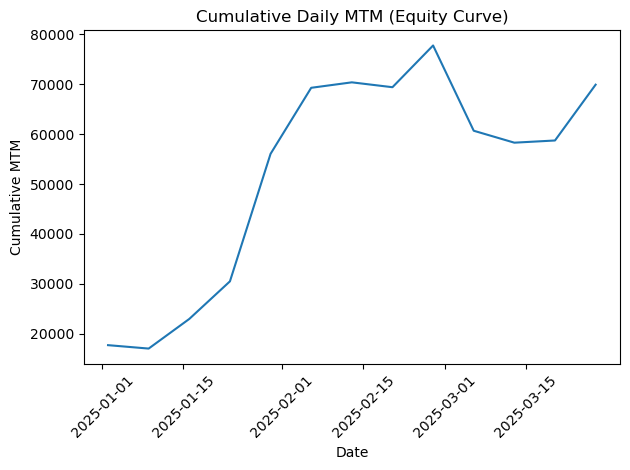

,Date,MTM,Cumulative_MTM
0,2025-01-02,17764.50,17764.50
1,2025-01-09,-682.50,17082.00
2,2025-01-16,5928.00,23010.00
3,2025-01-23,7517.25,30527.25
4,2025-01-30,25506.00,56033.25
5,2025-02-06,13211.25,69244.50
6,2025-02-13,1092.00,70336.50
7,2025-02-20,-975.00,69361.50
8,2025-02-27,8346.00,77707.50
9,2025-03-06,-17052.75,60654.75


In [7]:
generate_performance_report(trade_log)